In [ ]:
#用mongodb将会话结束数据这部分导出成csv文件（下面代码里的ends.csv为文件名）
#需要按每天分析，则每晚导出一天的数据；需要按周分析，则每周结束导出一周的数据,以此类推
#需要的fields: session_duration,device_id,app_key

In [1]:
#高、低、中频的用户聚类
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

ends = pd.read_csv('ends_all.csv')

#计算每个用户总使用时间
total_time = ends.groupby('device_id')['session_duration'].sum()
total_time = pd.DataFrame(list(total_time),columns = ['total_time'])

#计算每个用户使用次数
counts = ends.groupby('device_id').size()
counts= pd.DataFrame(list(counts),columns = ['counts'])


#得到每个用户使用的app_key和reset_index 后面得到的每个用户的device_id
app = ends.groupby('device_id')['app_key'].unique()
app = pd.DataFrame(app).reset_index()

#将前面得到的数据整理成一个data frame
user_data = pd.concat([app,counts,total_time],axis = 1)

#总使用时间/使用次数得到平均时间
user_data['avg_time'] = user_data.total_time/user_data.counts

In [3]:
#以统计出的使用次数的25%，25%-50%，75%来化分用户，分为低频用户，中频用户，高频用户
import numpy as np
quantile3 = np.quantile(user_data['counts'],0.75)
quantile1 = np.quantile(user_data['counts'],0.25)

#高频用户
import numpy as np
high = user_data[user_data['counts']>quantile3]

#中间用户
middle = user_data[(user_data['counts']<quantile3) & (user_data['counts']>quantile1)]

#低频用户
low = user_data[(user_data['counts']<quantile1)]

In [4]:
#根据使用平均时长和使用总次数，用k近邻算法计算机将用户分为三类
from sklearn.cluster import KMeans
X=user_data.loc[:,['counts','avg_time']]
clf_KMeans=KMeans(n_clusters=3)
cluster=clf_KMeans.fit_predict(X)

#给原数据集中的贴上分出来的三类类别标签（‘0’，‘1’，‘2’）
user_data['cluster'] = cluster
labels = np.unique(cluster)

#分别抽取出这三类用户
group1 = user_data[user_data['cluster'] == labels[0]]
group2 = user_data[user_data['cluster'] == labels[1]]
group3 = user_data[user_data['cluster'] == labels[2]]


#需要人工根据这步观察这三组那一部分是使用次数多，但是平均使用时间短；使用次数和平均时间都在中等及以下；使用次数少，但平均时间长的
#（例如这里分别是对应的group1，group2，group3）
[[group1.counts.mean(),group1.avg_time.mean()],[group2.counts.mean(),group2.avg_time.mean()],[group3.counts.mean(),group3.avg_time.mean()]]


[[8.757993763824855, 15.327885052908226],
 [4.923076923076923, 4123.754240631164],
 [56.89132856400228, 11.196137668250678]]

In [30]:
#可视化具体理解每一类别的用户使用的服务信息
#这部分使用的是扇形图，体现的主要是使用的服务占比的情况，后续可根据需要调整可视化选择的绘图方式
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib

#防止绘制出来的图加上中文坐标和标题名后乱码
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

#读取app_key对应的服务名称字典，此处为dca_dic
names = pd.read_excel('dca_dic.xlsx').dropna().loc[:,['服务名称','服务key']]
invdic =  names.set_index('服务key').T.to_dict('list')

#可视化的函数，输入的参数为每一类别的用户
def plot(category):
    x=list(itertools.chain.from_iterable(category.app_key)) #获取该类别用户所使用过的全部app_key
    y=dict(Counter(x)) #计数
    z = pd.DataFrame.from_dict(y, orient='index').reset_index()
    z.columns = ['服务ID','用户数']  #将计数结果转换为dataframe 方便作图
    z['服务名'] = list(map(lambda x:invdic.get(str(x)), z['服务ID'])) #将app_key转换为服务名称
    z = z.dropna() #字典里没有对应app_key的读取出来为空，此处直接过滤掉
    
    #调试图形大小
    fig1 = plt.figure(1,figsize = (15,15))
    #画扇形图
    patches, l_text, p_text = plt.pie(z.用户数, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    #加legend（图例）
    plt.legend(labels = z.服务名,loc = 'upper right',bbox_to_anchor = (1.2, 0.5))


C:\Users\91550\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


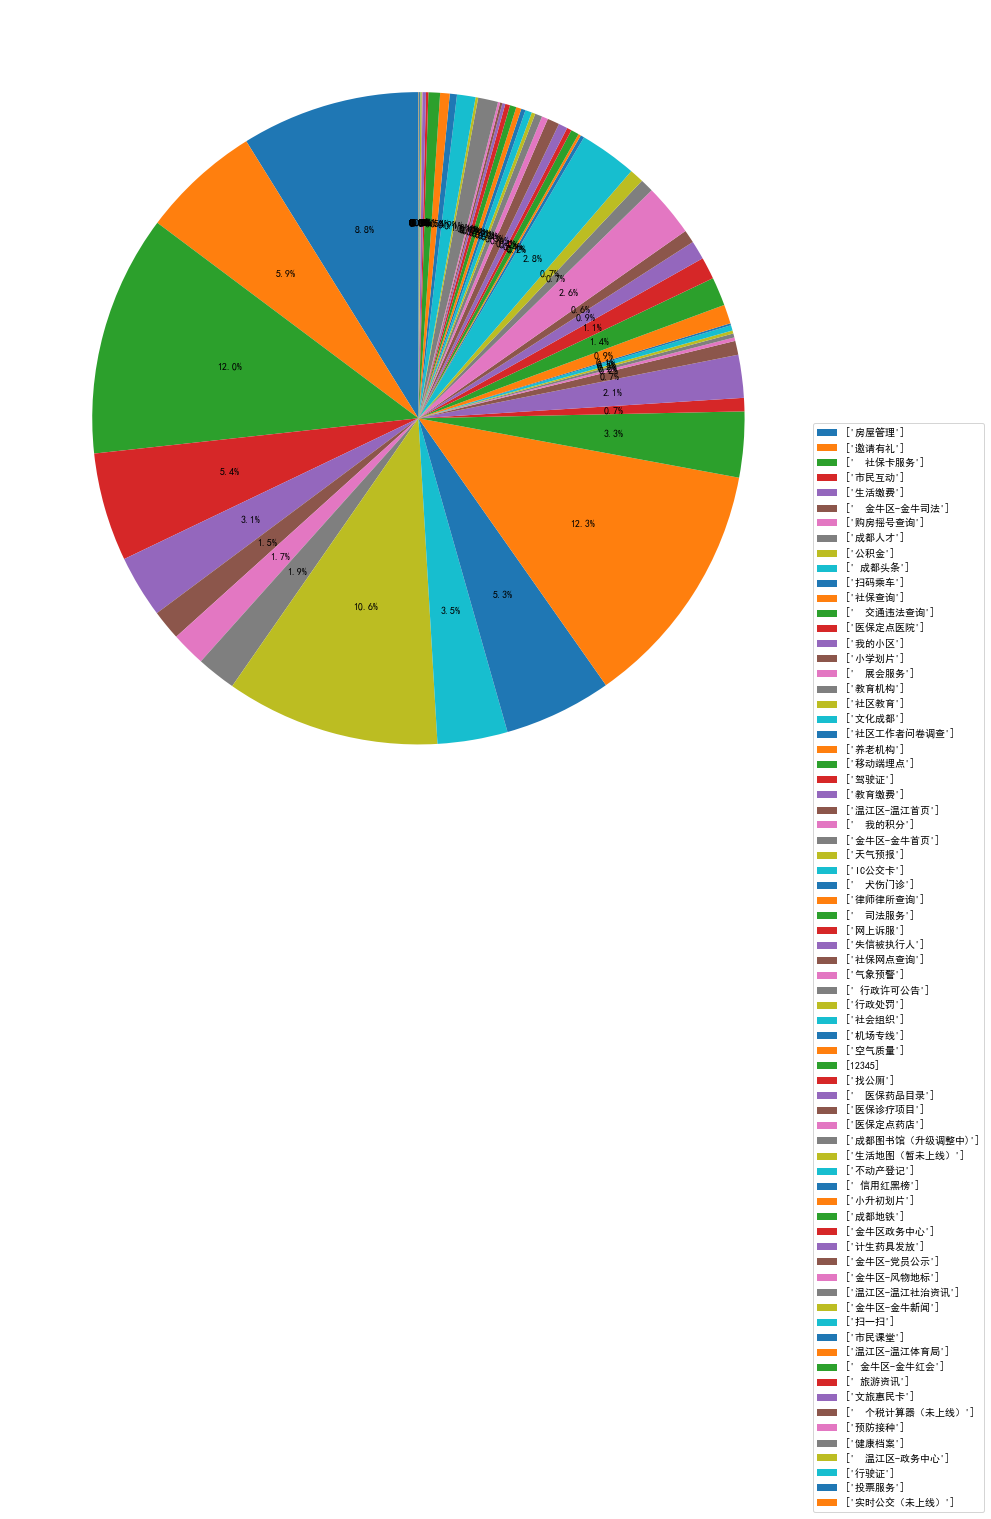

In [31]:
#以之前分出的group3这一类用户为例绘图如下
plot(group3)

In [32]:
#共现矩阵推荐算法部分，需要比较久的时间，建议以一周的数据量来分析，每周更新推荐算法所需要的这个标签关联度的矩阵（共现矩阵）
#用mongodb将会话结束数据这部分导出成csv文件（下面代码里的event.csv为文件名）
#需要的fields: device_id,app_key

#得到每个用户所使用过的服务信息（储存到‘tags’里）
events = pd.read_csv('event.csv')
tags = events.groupby('device_id')['app_key'].unique()


NameError: name 'im_tags' is not defined

In [35]:
tags = pd.DataFrame(tags).reset_index()

#category.xlsx是自定义使用过哪个服务被划归为具有哪个标签用户的文件
#读取文件，建立app_key对应的标签字典
import numpy as np
cate = pd.read_excel('category.xlsx')
need = cate.dropna().iloc[:,1:3]
need.columns = ['key','category']
dic = need.set_index('key').T.to_dict('list')

#贴标签函数
def assign_feature(user):
    tags = user.app_key
    raw = []
    for tag in tags:
        feature = dic.get(tag)
        raw.append(feature)
    final = list(filter(None,raw))
    return final

tags['features'] = tags.apply(assign_feature,axis = 1)

# 标记上的标签可能有格式不标准的地方，标准化格式方便后面操作
def standardization(x):
    return str(x.features).replace('[','').replace(']','').replace(",",' ').replace("'",'').replace('  ',' ').split(' ')
tags['std_features'] = tags.apply(standardization,axis = 1)

#去掉重复的标签
tags['unique_features'] = tags.std_features.apply(np.unique)

#只有标签数大于等于两个的用户信息才对建立共现矩阵有意义，选取出这一部分数据
tags['len'] = tags.unique_features.apply(len)
useful_data = tags[tags.len>1]


#建立空矩阵(
sets = list(map(str, list(range(1,13))))
edge = 12  #矩阵长宽为定义的标签数量
matrix = [[0 for j in range(edge)] for i in range(edge)]
matrix[0][1:] = np.array(sets)
matrix = list(map(list, zip(*matrix)))
matrix[0][1:] = np.array(sets)


# 建立共现矩阵（出于速度优化上的考虑，由于矩阵的性质，只需要上三角，然后下三角的数据在计算后取其对称即可，）
formated_data = list(useful_data.unique_features)
for row in range(1, len(matrix)):
    for col in range((row+1), len(matrix)):
        counter = 0
        for ech in formated_data:
            if matrix[0][row] in ech and matrix[col][0] in ech:
                counter += 1
            else:
                continue
            matrix[row][col] = counter
                        
            
# 自身出现次数不计，共现矩阵的下三角仅为对称
for row in range(1, len(matrix)):
    for col in range(1, len(matrix)):
        if row == col:
            matrix[row][col] = 0
        matrix[col][row] = matrix[row][col]
               
        
# 转换成 dataframe 方便看
co_matrix = pd.DataFrame(matrix).drop([0],axis = 1).drop([0],axis = 0)


#加入每个标签总共与其他标签一起出现的次数
co_matrix['total'] = co_matrix.iloc[:,0:12].sum(axis = 1)


#制作优化后表格
names = list(pd.read_excel('keys.xlsx').iloc[:,0])
edge = 12
nmatrix = [[0 for j in range(edge)] for i in range(edge)]
nmatrix[0][1:] = np.array(names)
nmatrix = list(map(list, zip(*nmatrix)))
nmatrix[0][1:] = np.array(names)


#将共现次数转换为共现概率
for row in range(1, len(nmatrix)):
    for col in range(1, len(nmatrix)):
        nmatrix[row][col] = (co_matrix.iloc[row-1,col-1])/(co_matrix.iloc[row-1].total)     
co_freq = pd.DataFrame(nmatrix)

#建议每周得到这个矩阵后存储成一个可供推荐算法使用的文件

In [ ]:
#在有了上一步标签关联度矩阵（co_freq)的基础上，建立推荐算法函数
#入参为用户此次点击的服务key（app_key）
#将app_key转换成对应标签后（例：dic.get(app_key),dic为app_key为key，标签为value的对应字典）
#查找此标签在关联度矩阵里关联度最大的一类标签
#输出值为那个标签对应的服务（标签为key,app_key为value的对应字典）

In [70]:
#一个简易的建立于用户本身使用频率的服务的排序函数，输出的为每个device_id使用频率前五的服务类型
def get_most_freq(device_id):
    user = events[events.device_id == device_id]
    user_app=list(user.app_key) #获取该用户所使用过的全部app_key
    user_count=dict(Counter(user_app)) #计数
    user_info = pd.DataFrame.from_dict(user_count, orient='index').reset_index()
    user_info.columns = ['app_key','counts']
    return user_info.sort_values(['counts'],ascending = False).head(5)